# PDB
The goal of this exercise is to extract and analyse pdb files<br>
We will learn how to:
* perform queries to the pdb database
* extract pdb IDs – each structure is defined by its ID code
* extract information about structures
* perform different analyses (e.g. find  structure with lowest resolution)

partially based on <br>
https://github.com/volkamerlab/TeachOpenCADD <br>
https://jcheminf.biomedcentral.com/articles/10.1186/s13321-019-0351-x

In [1]:
# import needed libraries
import math
import pypdb
import requests
import json

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt



# PDB Protein Data Bank
https://www.rcsb.org/

let's take a look at the human tyrosine-protein kinase ABL1<br>
its uniprot id is P00519<br>
you can also check it out at https://www.uniprot.org/uniprot/P00519

To perform a search in the PDB database, copy the uniprot id (P00519) to the search box at https://www.rcsb.org/

### Programmatic access to PDB

While performing search over the website is straightforward, making repeated searches to systematically analyze structures of interest is only possible using a programmatic access.


Details available:


https://www.rcsb.org/docs/programmatic-access/web-services-overview <br>
https://search.rcsb.org/index.html#basic-queries

In [2]:
# prepare search parameters using the uniprot ID of ABL1 (P00519)
search_dict = {
  "query": {
    "type": "terminal",
    "service": "full_text",
    "parameters": {
      "value": "P00519"
    }
  },
  "return_type": "entry",
  "request_options": {
    "paginate": {
      "start": 0,
      "rows": 100000
    }
  }
}

In [3]:
# performing the search
response = requests.get('https://search.rcsb.org/rcsbsearch/v2/query?json=' + json.dumps(search_dict))
data = response.json()
# printing the keys of the retreived dictionary
data.keys()

dict_keys(['query_id', 'result_type', 'total_count', 'result_set'])

In [4]:
# showing the total number of hits (how does this compare to the search performed on the website directly?)
data['total_count'], len(data['result_set'])

(76, 76)

In [5]:
data['result_set'][0]

{'identifier': '1AB2', 'score': 1.0}

In [6]:
def exctract_pdb_ids(search_result):
    pdb_IDs = []
    for entry in search_result['result_set']:
        pdb_IDs.append(entry['identifier'])
    return pdb_IDs

found_pdb_ids = exctract_pdb_ids(data)

In [7]:
# here we look at how many hits we got
print(len(found_pdb_ids))

76


In [8]:
# here we look at the first 5 pdb codes
print(found_pdb_ids[:5])

['1AB2', '4J9B', '4J9C', '4J9E', '4J9H']


In [9]:
# let's take a look at some information about one of the strcutures from the list (PDB ID 7DT2)
# it's a long list of info
pdb_id = found_pdb_ids[0]
pdb_info = pypdb.get_info(pdb_id)
print('PDB id:', pdb_id,'\n')
for k in pdb_info:
    #print(k,pdb_info[k],'\n') # this line would print all the data available (long output)!
    print(k) # here we just print the keys

PDB id: 1AB2 

audit_author
citation
entry
exptl
pdbx_audit_revision_category
pdbx_audit_revision_details
pdbx_audit_revision_group
pdbx_audit_revision_history
pdbx_audit_revision_item
pdbx_database_status
pdbx_nmr_ensemble
pdbx_vrpt_summary
rcsb_accession_info
rcsb_entry_container_identifiers
rcsb_entry_info
rcsb_primary_citation
struct
struct_keywords
rcsb_id


now try to do the same search direct on the PDB website https://www.rcsb.org/

In [10]:
# let's extract some of the (interesting) information
# of course, what is interesting depends on the project you are involved in
# this is one example of such a function
def extract_interesting_info(pdb_info):
    pdb_id = pdb_info['rcsb_id']
    desc = pdb_info['struct'].get('pdbx_descriptor')
    title = pdb_info['struct']['title']
    method = pdb_info['exptl'][0]['method']
    date = pdb_info['rcsb_accession_info']['deposit_date']
    num_atoms = pdb_info['rcsb_entry_info']['deposited_atom_count']
    # only for X-ray
    resolution, r, rfree = None, None, None
    resolution = pdb_info['pdbx_vrpt_summary'].get('pdbresolution')
    r = pdb_info['pdbx_vrpt_summary'].get('pdbr')
    rfree = pdb_info['pdbx_vrpt_summary'].get('pdbrfree')
    return pdb_id, desc, title, method, date, num_atoms, resolution, r, rfree

In [11]:
pdb_id = found_pdb_ids[0]
print('PDB id:', pdb_id,'\n')

extract_interesting_info(pypdb.get_info(pdb_id))

PDB id: 1AB2 



('1AB2',
 None,
 'THREE-DIMENSIONAL SOLUTION STRUCTURE OF THE SRC HOMOLOGY 2 DOMAIN OF C-ABL',
 'SOLUTION NMR',
 '1993-07-19T00:00:00+0000',
 860,
 None,
 None,
 None)

In [12]:
# let’s collect data for all retrieved pdb codes
pdb_data = []
for pdb_id in found_pdb_ids:
    #print(pdb_id)
    #pdb_data.append(pypdb.describe_pdb(pdb_id))
    pdb_data.append(extract_interesting_info(pypdb.get_info(pdb_id)))

In [13]:
# now we store this data in a pandas dataframe
pdbs = pd.DataFrame(pdb_data, columns = ['ID', 'desc', 'title', 'method', 'date', 'num_atoms', 'resolution', 'r', 'rfree'])
pdbs.head()# this function outputs first 5 lines of a dataframe

,ID,desc,title,method,date,num_atoms,resolution,r,rfree
0,1AB2,None,THREE-DIMENSIONAL SOLUTION STRUCTURE OF THE SR...,SOLUTION NMR,1993-07-19T00:00:00+0000,860,NaN,None,NaN
1,4J9B,Tyrosine-protein kinase ABL1 (E.C.2.7.10.2),Crystal structure of the Abl-SH3 domain H59Q-N...,X-RAY DIFFRACTION,2013-02-16T00:00:00+0000,517,1.70,None,0.21
2,4J9C,"Tyrosine-protein kinase ABL1 (E.C.2.7.10.2), P17",Crystal structure of the Abl-SH3 domain H59Q-N...,X-RAY DIFFRACTION,2013-02-16T00:00:00+0000,634,1.05,None,0.16
3,4J9E,PROTO-ONCOGENE TYROSINE-PROTEIN KINASE ABL1 (E...,Crystal structure of the N114A mutant of the A...,X-RAY DIFFRACTION,2013-02-16T00:00:00+0000,1745,1.40,None,0.19
4,4J9H,"Tyrosine-protein kinase ABL1 (E.C.2.7.10.2), P7",Crystal structure of the ABL-SH3 domain comple...,X-RAY DIFFRACTION,2013-02-16T00:00:00+0000,3545,1.70,None,0.21


#### Let's make some plots
looking at the release years and resolution of the structures

In [14]:
pdbs.date = pd.to_datetime(pdbs.date)
#pdbs.head().date

<AxesSubplot: xlabel='date'>

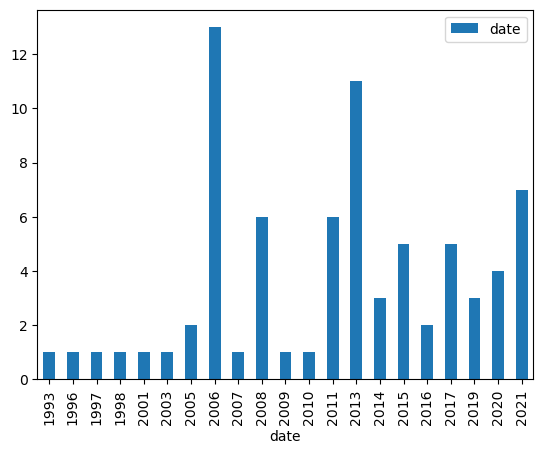

In [15]:
df = pdbs
df[['date']].groupby(df["date"].dt.year).count().plot(kind="bar")

In [16]:
years = []
for rel_date in pdbs.date:
    year = int(rel_date.year)
    years.append(year)
print(years[:5])

[1993, 2013, 2013, 2013, 2013]


In [17]:
sorted(years)[:5]

[1993, 1996, 1997, 1998, 2001]

Text(0, 0.5, '# structures')

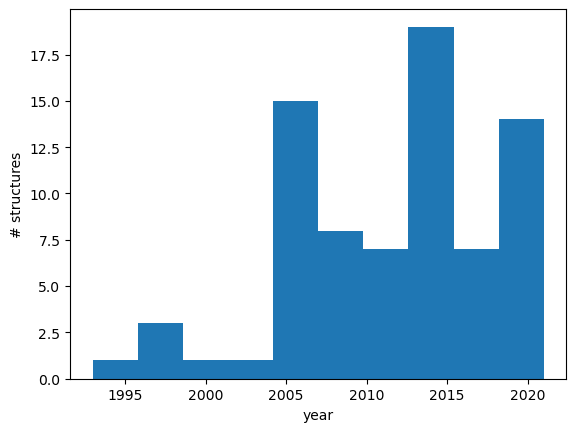

In [18]:
plt.hist(years)
plt.xlabel('year')
plt.ylabel('# structures')

Text(0, 0.5, '# structures')

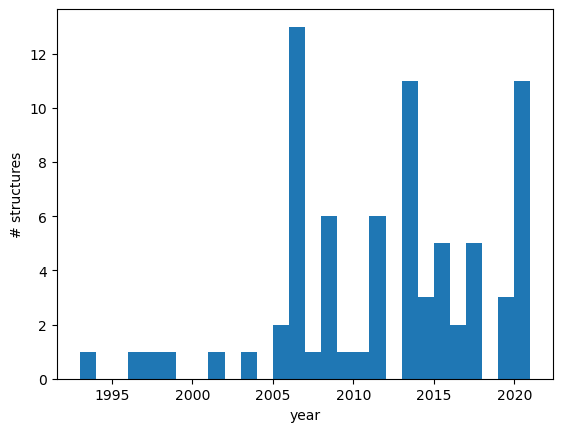

In [19]:
plt.hist(years, bins = max(years) - min(years))
plt.xlabel('year')
plt.ylabel('# structures')

In [20]:
pdbs['year'] = years

In [21]:
pdbs = pdbs.sort_values(["year"], 
                        ascending=True, 
                        na_position='last')
pdbs[['date', 'year', 'resolution']].head(10)

,date,year,resolution
0,1993-07-19 00:00:00+00:00,1993,NaN
16,1996-11-17 00:00:00+00:00,1996,2.50
12,1997-10-03 00:00:00+00:00,1997,NaN
13,1998-04-28 00:00:00+00:00,1998,1.65
60,2001-08-23 00:00:00+00:00,2001,NaN
14,2003-03-06 00:00:00+00:00,2003,3.42
15,2005-06-14 00:00:00+00:00,2005,NaN
18,2005-11-23 00:00:00+00:00,2005,1.91
26,2006-08-08 00:00:00+00:00,2006,2.80
25,2006-08-08 00:00:00+00:00,2006,2.10


In [22]:
pdbs.keys()

Index(['ID', 'desc', 'title', 'method', 'date', 'num_atoms', 'resolution', 'r',
       'rfree', 'year'],
      dtype='object')

In [23]:
pdbs.method.unique()

array(['SOLUTION NMR', 'X-RAY DIFFRACTION'], dtype=object)

In [24]:
pdbs[pdbs.method=='X-RAY DIFFRACTION'].head()

,ID,desc,title,method,date,num_atoms,resolution,r,rfree,year
16,2ABL,ABL TYROSINE KINASE,SH3-SH2 DOMAIN FRAGMENT OF HUMAN BCR-ABL TYROS...,X-RAY DIFFRACTION,1996-11-17 00:00:00+00:00,1321,2.50,None,0.27,1996
13,1BBZ,"ABL TYROSINE KINASE, PEPTIDE P41",CRYSTAL STRUCTURE OF THE ABL-SH3 DOMAIN COMPLE...,X-RAY DIFFRACTION,1998-04-28 00:00:00+00:00,2415,1.65,None,0.27,1998
14,1OPL,None,Structural basis for the auto-inhibition of c-...,X-RAY DIFFRACTION,2003-03-06 00:00:00+00:00,6655,3.42,None,0.32,2003
18,2F4J,None,Structure of the Kinase Domain of an Imatinib-...,X-RAY DIFFRACTION,2005-11-23 00:00:00+00:00,2572,1.91,None,0.24,2005
26,2HZ4,Proto-oncogene tyrosine-protein kinase ABL1 (E...,Abl kinase domain unligated and in complex wit...,X-RAY DIFFRACTION,2006-08-08 00:00:00+00:00,6518,2.80,None,0.28,2006


In [25]:
pdbs[pdbs.method=='X-RAY DIFFRACTION'].head().resolution

16    2.50
13    1.65
14    3.42
18    1.91
26    2.80
Name: resolution, dtype: float64

array([[<AxesSubplot: title={'center': 'resolution'}>]], dtype=object)

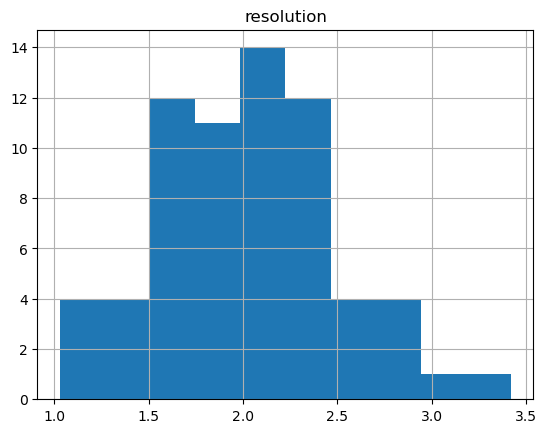

In [26]:
pdbs.hist(column = 'resolution')

# Exercises & Questions
## Required
* Perform a PDB query on a protein of choice (e.g. from a uniprot ID or by textual input query) and retrieve the data from the PDB database - note to use a query that will lead to some tens or hundreds of structures
* How many structures have you retrieved and how many of them are X-ray and how many NMR?
* Sort the structures by the resolution
* What is the min and max resolution
* From the sorted list of the task above, report from which structures are they obtained.

## Additional (at least one of the three)
* chose one of the X-ray and one of the NMR structures and use pymol to visualize them (save visualizations as png files) - this task (pymol) only works on a local machine:<br>
pymol selection algebra might be helpful for this task https://pymolwiki.org/index.php/Selection_Algebra
   - visualize secondary structure elements
   - zoom to the ligand (if present)
   - for the X-ray structure, visualize b-factors by either changing the size of the atoms (spheres, see https://sourceforge.net/p/pymol/mailman/message/29616429/) or by color and cartoon thickness (see https://www.michaelchimenti.com/2014/09/five-cool-features-in-pymol-that-you-may-have-missed/)
   - for the X-ray structure, visualize electron density map (it has to be obtained in a separate file, e.g. from PDB web page), using mesh representation (see L03_Xray presentation, slide 18)
   - for the NMR structure, visualize the bundle. An NMR bundle is a set of structures that satisfy experimental data. This set of structures is reported within one PDB file.
* plot the energy (similar to L02_energy_FF, slide 11) and the force as a function of the relevant coordinate (e.g. distance for the bond and angle for the angle term) for different FF terms using realist parameters (e.g. L02_energy_FF, slide 11 for the bonds) and compare them
    - e.g. (bonds, angles, dihedrals and van der Waals)
* Analyse pdb structures in more detail:
    - plot B-factors (min, max, average) against resolution (scatter plot, where each point corresponds to one pdb code)
    - extract ligands and draw chemical structures of some of them (see talktorial 8 from 
https://jcheminf.biomedcentral.com/articles/10.1186/s13321-019-0351-x)

# Space for answers and solutions
please provide your answers/soloutions below this cell